In [ ]:
# Geometric distance L2norm Regression for Homography

In [194]:
import numpy as np

In [517]:
# Data init 
M = 4  # number of data
N = 3  # features number
data_x = np.random.rand(N,M)*1000
data_x = data_x
data_x[2,:] = 1
t_m = np.random.rand(N,N)
t_m[2,2] = 1
data_y = np.dot(t_m,data_x.copy().astype(float))

In [518]:
data_x

array([[159.80342918, 507.49942448,  50.20430764, 924.49209985],
       [  6.46182464, 886.75590704, 543.98732743, 970.74640022],
       [  1.        ,   1.        ,   1.        ,   1.        ]])

In [519]:
t_m = np.array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [520]:
data_y = np.dot(t_m, data_x.copy().astype(float))
print(data_y)

[[5.61810520e+02 9.09650978e+02 5.19169086e+02 1.24692776e+03]
 [5.04552924e+01 8.47723210e+02 5.80258866e+02 8.72551513e+02]
 [9.66665354e-01 9.08077713e-01 9.98249628e-01 8.22174312e-01]]


In [419]:
t_m = np.array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
 [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
 [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])
data_y = np.dot(t_m, data_x.copy().astype(float))

In [826]:
DBG = 1
def DEBUG(*args):
    if DBG: print(*args)

def DEBUGLOSS(*args):
    print(*args)

In [827]:
DEBUG("1")

1


In [828]:
class Variables(object):
    """
    Variable that can used to train with mask
    """
    __slots__ = ('train_mask','dim','trainable','val')
    def __init__(self, val=None, dim=None, trainable=1):
        self.dim = dim
        if val is None:
            self.val = np.random.rand(dim[0],dim[1])
            #self.val = np.zeros((dim[0],dim[1]))
        else:
            assert val.shape == dim, "input val not consistent to dim input"
            self.val = val
        self.train_mask = np.ones_like(self.val)
        self.trainable = trainable
    def set_trainMask(self, mask):
        assert mask.shape == self.dim
        self.train_mask = mask
    def update(self, dv):
        if self.trainable:
            self.val -= (dv * self.train_mask)


array([0.79227236, 0.08221177, 3.9888977 ])

In [1011]:
class Regression(object):
    """
    Note. Training gradient may explode if lr is too large.
    """
    __slots__ = ('var', 'iter', 'lr', 'err_th', 'j_hist',
                'x_mean', 'y_mean', 'x_std', 'y_std',
                'decay_rate', 'loss_weights','norm', 'update_steps', 'dim','data_m')
    def __init__(self, var=None, dim=None, iter=500, decay_rate=0.9, norm=1, update_steps=100, data_m=0):
        self.var = var
        self.iter = iter
        self.lr = 0.001
        self.err_th = 1e-4
        self.j_hist = np.zeros((self.iter,1))
        self.decay_rate=0.9
        self.loss_weights=None
        self.update_steps=update_steps
        self.norm = norm
        self.data_m = data_m

    def process(self, x, y, method=0):
        if method == 0:
            return x.copy(), y.copy()
        elif method == 1:
            n, m = x.shape
            self.x_std = np.std(x,axis=1, keepdims=1)
            _x = x.copy() / self.x_std
            _y = y.copy() / self.x_std
            _x[-1,:] = x[-1,:]
            _y[-1,:] = y[-1,:]
            return _x, _y
        elif method == 2:
            self.x_mean = np.mean(x,axis=1, keepdims=1)
            self.x_std = np.std(x,axis=1, keepdims=1)
            _x = (x.copy() - self.x_mean)/self.x_std
            _y = (y.copy() - self.x_mean)/self.x_std
            return _x, _y
        return x.copy(), y.copy()
    
    def pred(W,x):
        return np.dot(W, x)
    
    def compute_cost(x, val, y):
        m, n = y.shape
        pred = Regression.pred(x, val)
        dloss = pred - y
        cost = np.sum(dloss * dloss) / (2 * m * n)
        
    def fit(self, x, y):
        assert len(x.shape) == 2, 'shape of x is not support'
        assert self.var.dim[1] == x.shape[0], 'shape of x %s is not consistent to var dim %s' % (self.var.dim, x.shape)
        assert self.var.dim[0] == y.shape[0], 'shape of y %s is not consistent to var dim %s' % (self.var.dim, y.shape)
        n, m = x.shape
        p, q = self.var.val.shape
        print('processing data')
        _x, _y = self.process(x, y, self.data_m)
        print('output:', _x[:,0], _y[:,0])
        dv_hist = []
        lr= self.lr
        method = 'L2norm'
        for i in range(self.iter):
            # update policy
            lr = self.lrPolicy(i)
            #if (i+1) % self.update_steps == 0:
            #    lr *= self.decay_rate
            pred = Regression.pred(self.var.val, _x)
            DEBUG('pred',pred[:,0])
            # Loss L2norm
            res = self.lossDiff(pred,y)
            #if self.loss_weights is not None:
            #    res = (pred - _y) * self.loss_weights
            #    DEBUG('res',res[0,:], '\ntv', np.dot(res, _x.T)[0,:])
            #else:
            #    res = (pred - _y)
            loss = self.computeLoss(res)
            loss = self.addNorm(loss)
            #if method == 'L2norm':
            #    loss = np.sum(res * res) / (2 * m * n)
            #if self.norm > 0:
            #    loss += (np.sum(self.var.val ** 2) - 1) / (2 * p * q) * self.norm 
            self.j_hist[i,0] = loss
            if (loss < self.err_th):
                return self.var.val
            # Gradient
            tV = self.computeGradient(res, _x, m)
            dV = self.computeSolver(lr, tV)
            #if method == 'L2norm':
            #    tV = np.dot(res, _x.T) / m
            #    if self.norm > 0:
            #        tV += self.var.val * self.norm 
            #    dV = lr * tV
            #    dv_hist.append(dV[0,0])
            dv_hist.append(dV[0,0])
            # Update variable
            self.updateWeight(dV * self.var.train_mask)
            #if self.var.trainable:
            #    self.var.val -= (dV * self.var.train_mask)
            DEBUG('dv',dV[0,:],'val',self.var.val[0,:])
            DEBUGLOSS('==============',i,'============', 'loss',loss, lr)
        print("iter Done! Final loss:", loss)
        return dv_hist
            #self.var.update(dV, self.ir, m)

In [1202]:
var  = Variables(dim=(N,N))
# var.val[:,-1] = 200
var.val[-1,-1] = 1.0
mask = np.ones_like(t_m)
mask[-1,:] = 1
mask[N-1,N-1] = 0
var.set_trainMask(mask)
reg = Regression(var=var,iter=2000, update_steps=50, data_m=0)
reg.err_th = 1e-15
#reg.lr = 0.000002
reg.lr = np.ones((N,N)) * 0.000002
reg.lr[:,2] = 0.1
reg.norm = 0
reg.loss_weights = np.array([[1,1,1]]).T

In [1203]:
reg.lr

array([[2.e-06, 2.e-06, 1.e-01],
       [2.e-06, 2.e-06, 1.e-01],
       [2.e-06, 2.e-06, 1.e-01]])

In [1204]:
data_x

array([[159.80342918, 507.49942448,  50.20430764, 924.49209985],
       [  6.46182464, 886.75590704, 543.98732743, 970.74640022],
       [  1.        ,   1.        ,   1.        ,   1.        ]])

In [1205]:
data_y

array([[5.61810520e+02, 9.09650978e+02, 5.19169086e+02, 1.24692776e+03],
       [5.04552924e+01, 8.47723210e+02, 5.80258866e+02, 8.72551513e+02],
       [9.66665354e-01, 9.08077713e-01, 9.98249628e-01, 8.22174312e-01]])

In [1206]:
x_mean = np.mean(data_x, axis=1, keepdims=1)
x_mean[2,0] = 0
_data_x = (data_x) / np.array([[100,100,100]]).T
_data_y = (data_y) / np.array([[100,100,100]]).T

In [1207]:
DEG = 1

In [1208]:
dv_hist = reg.fit(data_x, data_y)

processing data
output: [159.80342918   6.46182464   1.        ] [561.8105203   50.45529236   0.96666535]
pred [21.3295705  55.32561898 99.69999589]
res [-540.4809498  -274.75049931 -156.25420482 -514.0511035 ] 
tv [-708887.24773569 -831142.68687988   -1485.53675743]
dv [ -0.35444362  -0.41557134 -37.13841894] val [ 0.45718554  1.07199738 37.80776844]
============== 0 ============ loss 96242.35165295303 [[2.e-06 2.e-06 1.e-01]
 [2.e-06 2.e-06 1.e-01]
 [2.e-06 2.e-06 1.e-01]]
pred [117.79464513 141.55400639   8.81985997]
res [-444.01587517  310.77819834  124.74435532  254.18203122] 
tv [3.28016481e+05 5.87320891e+05 2.45688710e+02]
dv [0.16400824 0.29366045 6.14221774] val [ 0.2931773   0.77833693 31.66555069]
============== 1 ============ loss 38350.73857368661 [[2.e-06 2.e-06 1.e-01]
 [2.e-06 2.e-06 1.e-01]
 [2.e-06 2.e-06 1.e-01]]
pred [83.54576583 84.15786845 51.49113972]
res [-478.26475447  -39.00324167  -49.37934342 -188.65432944] 
tv [-273110.96343943 -247674.06617327    -755.301

dv [-7.52977859e-04  2.80647307e-03 -1.86354303e+00] val [7.66449229e-01 1.94848096e-01 3.57243273e+02]
============== 66 ============ loss 305.9081922183364 [[1.8e-06 1.8e-06 9.0e-02]
 [1.8e-06 1.8e-06 9.0e-02]
 [1.8e-06 1.8e-06 9.0e-02]]
pred [480.98356228  50.33873111   1.36034739]
res [-80.82695802   9.34753745 -17.45186503   8.03986111] 
tv [-1615.92591093  6077.76723054   -80.8914245 ]
dv [-7.27166660e-04  2.73499525e-03 -1.82005705e+00] val [7.67176396e-01 1.92113101e-01 3.59063330e+02]
============== 67 ============ loss 291.60268164671953 [[1.8e-06 1.8e-06 9.0e-02]
 [1.8e-06 1.8e-06 9.0e-02]
 [1.8e-06 1.8e-06 9.0e-02]]
pred [482.90214999  50.3196008    1.33601567]
res [-78.90837031   9.11135796 -17.08310384   7.87719119] 
tv [-1561.06361662  5923.42143693   -79.00292499]
dv [-7.02478627e-04  2.66553965e-03 -1.77756581e+00] val [7.67878874e-01 1.89447561e-01 3.60840896e+02]
============== 68 ============ loss 277.9690046314059 [[1.8e-06 1.8e-06 9.0e-02]
 [1.8e-06 1.8e-06 9.0e-0

res [-24.42736133   2.73061203  -5.57458908   2.61576698] 
tv [-379.4045515  1770.28158127  -24.65557141]
dv [-1.53658843e-04  7.16964040e-04 -4.99275321e-01] val [7.85375713e-01 1.15130535e-01 4.11652671e+02]
============== 119 ============ loss 26.75522669907824 [[1.62e-06 1.62e-06 8.10e-02]
 [1.62e-06 1.62e-06 8.10e-02]
 [1.62e-06 1.62e-06 8.10e-02]]
pred [537.9023566   50.27860435   0.98203105]
res [-23.9081637    2.67209702  -5.45761878   2.56110843] 
tv [-370.79030678 1732.31879067  -24.13257702]
dv [-1.50170074e-04  7.01589110e-04 -4.88684685e-01] val [7.85525883e-01 1.14428946e-01 4.12141356e+02]
============== 120 ============ loss 25.630711526686664 [[1.62e-06 1.62e-06 8.10e-02]
 [1.62e-06 1.62e-06 8.10e-02]
 [1.62e-06 1.62e-06 8.10e-02]]
pred [538.41050544  50.28167188   0.98117634]
res [-23.40001486   2.61485465  -5.3430505    2.50755906] 
tv [-362.3910034  1695.18317907  -23.62065166]
dv [-1.46768356e-04  6.86549188e-04 -4.78318196e-01] val [7.85672651e-01 1.13742397e-01 4

dv [-4.77011869e-05  2.29261621e-04 -1.60511409e-01] val [7.89835421e-01 9.39688633e-02 4.26434453e+02]
============== 169 ============ loss 3.4095151558291312 [[1.458e-06 1.458e-06 7.290e-02]
 [1.458e-06 1.458e-06 7.290e-02]
 [1.458e-06 1.458e-06 7.290e-02]]
pred [553.26007189  50.38643485   0.96765925]
res [-8.55044841  0.95194093 -1.96362179  0.92323898] 
tv [-128.33663351  616.93328894   -8.6388903 ]
dv [-4.67787029e-05  2.24872184e-04 -1.57443776e-01] val [7.89882200e-01 9.37439911e-02 4.26591897e+02]
============== 170 ============ loss 3.2804104317516116 [[1.458e-06 1.458e-06 7.290e-02]
 [1.458e-06 1.458e-06 7.290e-02]
 [1.458e-06 1.458e-06 7.290e-02]]
pred [553.42353798  50.38771489   0.96760949]
res [-8.38698232  0.93371814 -1.92615714  0.90563543] 
tv [-125.85570344  605.12212109   -8.4737859 ]
dv [-4.58744039e-05  2.20567013e-04 -1.54434748e-01] val [7.89928074e-01 9.35234241e-02 4.26746331e+02]
============== 171 ============ loss 3.156194396279466 [[1.458e-06 1.458e-06 7.2

res [-3.96682949  0.44138665 -0.91178165  0.42881211] 
tv [-59.25144627 286.03940753  -4.00841239]
dv [-1.94374370e-05  9.38352276e-05 -6.57479842e-02] val [7.91163217e-01 8.75713572e-02 4.30915473e+02]
============== 211 ============ loss 0.706121640022345 [[1.3122e-06 1.3122e-06 6.5610e-02]
 [1.3122e-06 1.3122e-06 6.5610e-02]
 [1.3122e-06 1.3122e-06 6.5610e-02]]
pred [557.91193862  50.42351719   0.96678844]
res [-3.89858168  0.43379018 -0.896103    0.42143964] 
tv [-58.2290699  281.11638923  -3.93945487]
dv [-1.91020464e-05  9.22202315e-05 -6.46169084e-02] val [7.91182319e-01 8.74791370e-02 4.30980090e+02]
============== 212 ============ loss 0.6820342347710627 [[1.3122e-06 1.3122e-06 6.5610e-02]
 [1.3122e-06 1.3122e-06 6.5610e-02]
 [1.3122e-06 1.3122e-06 6.5610e-02]]
pred [557.97901218  50.4240601    0.96678289]
res [-3.83150811  0.42632453 -0.88069372  0.41419378] 
tv [-57.22442275 276.27815855  -3.87168353]
dv [-1.87724719e-05  9.06330499e-05 -6.35052890e-02] val [7.91201092e-01 8

tv [-26.17968015 126.52733877  -1.77344706]
dv [-7.72941967e-06  3.73565641e-05 -2.61800689e-02] val [7.91781025e-01 8.45869602e-02 4.33006800e+02]
============== 259 ============ loss 0.13821351800580664 [[1.18098e-06 1.18098e-06 5.90490e-02]
 [1.18098e-06 1.18098e-06 5.90490e-02]
 [1.18098e-06 1.18098e-06 5.90490e-02]]
pred [560.08270923  50.44116683   0.96667953]
res [-1.72781107  0.19222318 -0.39723312  0.18683314] 
tv [-25.77403403 124.56803878  -1.74598788]
dv [-7.60965468e-06  3.67780906e-05 -2.57747095e-02] val [7.91788635e-01 8.45501821e-02 4.33032575e+02]
============== 260 ============ loss 0.1339665385269907 [[1.18098e-06 1.18098e-06 5.90490e-02]
 [1.18098e-06 1.18098e-06 5.90490e-02]
 [1.18098e-06 1.18098e-06 5.90490e-02]]
pred [560.10946233  50.44138519   0.96667896]
res [-1.70105797  0.18924659 -0.39108319  0.18394072] 
tv [-25.37468088 122.63908389  -1.71895385]
dv [-7.49174766e-06  3.62085763e-05 -2.53756264e-02] val [7.91796127e-01 8.45139735e-02 4.33057950e+02]
=====

============== 324 ============ loss 0.019663140535749263 [[1.062882e-06 1.062882e-06 5.314410e-02]
 [1.062882e-06 1.062882e-06 5.314410e-02]
 [1.062882e-06 1.062882e-06 5.314410e-02]]
pred [561.15779792  50.44995188   0.96666643]
res [-0.65272238  0.07261419 -0.15007318  0.07058616] 
tv [-9.73358179 47.05664327 -0.6595952 ]
dv [-2.58641222e-06  1.25039148e-05 -8.76339834e-03] val [7.92089356e-01 8.30965367e-02 4.34051343e+02]
============== 325 ============ loss 0.019118934006880372 [[1.062882e-06 1.062882e-06 5.314410e-02]
 [1.062882e-06 1.062882e-06 5.314410e-02]
 [1.062882e-06 1.062882e-06 5.314410e-02]]
pred [561.16689384  50.45002628   0.96666639]
res [-0.64362646  0.07160227 -0.14798191  0.06960255] 
tv [-9.5979239  46.40088189 -0.65040354]
dv [-2.55036514e-06  1.23296655e-05 -8.64127771e-03] val [7.92091906e-01 8.30842071e-02 4.34059985e+02]
============== 326 ============ loss 0.018589789199489743 [[1.062882e-06 1.062882e-06 5.314410e-02]
 [1.062882e-06 1.062882e-06 5.314410e-

res [-0.33148447  0.03687684 -0.07621522  0.03584755] 
tv [-4.94293999 23.8975208  -0.33497531]
dv [-1.18209644e-06  5.71505506e-06 -4.00544131e-03] val [7.92179293e-01 8.26617297e-02 4.34356080e+02]
============== 376 ============ loss 0.004930982805827731 [[9.565938e-07 9.565938e-07 4.782969e-02]
 [9.565938e-07 9.565938e-07 4.782969e-02]
 [9.565938e-07 9.565938e-07 4.782969e-02]]
pred [561.48319324  50.45261389   0.96666553]
res [-0.32732706  0.03641433 -0.07525935  0.03539796] 
tv [-4.8809442  23.59780122 -0.33077412]
dv [-1.16727024e-06  5.64337759e-06 -3.95520588e-03] val [7.92180460e-01 8.26560864e-02 4.34360035e+02]
============== 377 ============ loss 0.004808071599696894 [[9.565938e-07 9.565938e-07 4.782969e-02]
 [9.565938e-07 9.565938e-07 4.782969e-02]
 [9.565938e-07 9.565938e-07 4.782969e-02]]
pred [561.48729852  50.45264748   0.96666552]
res [-0.32322178  0.03595763 -0.07431547  0.03495401] 
tv [-4.81972602 23.30184072 -0.32662562]
dv [-1.15263001e-06  5.57259909e-06 -3.905

 [8.6093442e-07 8.6093442e-07 4.3046721e-02]]
pred [561.62801189  50.45379887   0.96666539]
res [-0.18250841  0.02030358 -0.04196261  0.01973698] 
tv [-2.72143966 13.1574503  -0.18443047]
dv [-5.85745269e-07  2.83192546e-06 -1.98478170e-03] val [7.92221055e-01 8.24598208e-02 4.34497590e+02]
============== 426 ============ loss 0.001494765236815523 [[8.6093442e-07 8.6093442e-07 4.3046721e-02]
 [8.6093442e-07 8.6093442e-07 4.3046721e-02]
 [8.6093442e-07 8.6093442e-07 4.3046721e-02]]
pred [561.63007198  50.45381572   0.96666539]
res [-0.18044832  0.0200744  -0.04148896  0.01951419] 
tv [-2.69072065 13.00893368 -0.18234868]
dv [-5.79133506e-07  2.79995969e-06 -1.96237824e-03] val [7.92221634e-01 8.24570208e-02 4.34499552e+02]
============== 427 ============ loss 0.0014612109923180067 [[8.6093442e-07 8.6093442e-07 4.3046721e-02]
 [8.6093442e-07 8.6093442e-07 4.3046721e-02]
 [8.6093442e-07 8.6093442e-07 4.3046721e-02]]
pred [561.63210881  50.45383239   0.96666539]
res [-0.17841149  0.0198478

res [-0.11696911  0.0130125  -0.02689374  0.01264938] 
tv [-1.74415529  8.43256713 -0.11820096]
dv [-3.37860747e-07  1.63347464e-06 -1.14483689e-03] val [7.92239442e-01 8.23709248e-02 4.34559893e+02]
============== 467 ============ loss 0.0006139735133900161 [[7.74840978e-07 7.74840978e-07 3.87420489e-02]
 [7.74840978e-07 7.74840978e-07 3.87420489e-02]
 [7.74840978e-07 7.74840978e-07 3.87420489e-02]]
pred [561.69473946  50.4543449    0.96666537]
res [-0.11578084  0.01288031 -0.02662053  0.01252088] 
tv [-1.72643654  8.34690178 -0.11700018]
dv [-3.34428445e-07  1.61688039e-06 -1.13320665e-03] val [7.92239777e-01 8.23693079e-02 4.34561027e+02]
============== 468 ============ loss 0.0006015623340768369 [[7.74840978e-07 7.74840978e-07 3.87420489e-02]
 [7.74840978e-07 7.74840978e-07 3.87420489e-02]
 [7.74840978e-07 7.74840978e-07 3.87420489e-02]]
pred [561.69591567  50.45435452   0.96666537]
res [-0.11460463  0.01274946 -0.02635009  0.01239368] 
tv [-1.7088978   8.2621067  -0.11581159]
dv [

res [-0.07150971  0.00795526 -0.01644164  0.00773327] 
tv [-1.06629675  5.1552953  -0.07226282]
dv [-1.85897343e-07  8.98770161e-07 -6.29912180e-04] val [7.92252216e-01 8.23091681e-02 4.34603176e+02]
============== 517 ============ loss 0.00022947605013447743 [[6.9735688e-07 6.9735688e-07 3.4867844e-02]
 [6.9735688e-07 6.9735688e-07 3.4867844e-02]
 [6.9735688e-07 6.9735688e-07 3.4867844e-02]]
pred [561.7396644   50.45471253   0.96666536]
res [-0.0708559   0.00788253 -0.01629132  0.00766257] 
tv [-1.0565476   5.10816054 -0.07160212]
dv [-1.84197684e-07  8.90552725e-07 -6.24152909e-04] val [7.92252400e-01 8.23082776e-02 4.34603800e+02]
============== 518 ============ loss 0.00022529904551166235 [[6.9735688e-07 6.9735688e-07 3.4867844e-02]
 [6.9735688e-07 6.9735688e-07 3.4867844e-02]
 [6.9735688e-07 6.9735688e-07 3.4867844e-02]]
pred [561.74031223  50.45471783   0.96666536]
res [-0.07020807  0.00781046 -0.01614237  0.00759251] 
tv [-1.04688758  5.06145674 -0.07094747]
dv [-1.82513565e-07 

tv [-0.65719619  3.17739228 -0.04453816]
dv [-1.03117563e-07  4.98549682e-07 -3.49413648e-04] val [7.92259934e-01 8.22718535e-02 4.34629328e+02]
============== 572 ============ loss 8.717100433704214e-05 [[6.27621192e-07 6.27621192e-07 3.13810596e-02]
 [6.27621192e-07 6.27621192e-07 3.13810596e-02]
 [6.27621192e-07 6.27621192e-07 3.13810596e-02]]
pred [561.76680898  50.45493466   0.96666536]
res [-0.04371132  0.00486276 -0.01005019  0.00472707] 
tv [-0.65178832  3.15124654 -0.04417167]
dv [-1.02269041e-07  4.94447277e-07 -3.46538436e-04] val [7.92260036e-01 8.22713591e-02 4.34629675e+02]
============== 573 ============ loss 8.574230266719759e-05 [[6.27621192e-07 6.27621192e-07 3.13810596e-02]
 [6.27621192e-07 6.27621192e-07 3.13810596e-02]
 [6.27621192e-07 6.27621192e-07 3.13810596e-02]]
pred [561.76716867  50.4549376    0.96666536]
res [-0.04335163  0.00482275 -0.00996749  0.00468818] 
tv [-0.64642496  3.12531594 -0.04380819]
dv [-1.01427501e-07  4.90378630e-07 -3.43686883e-04] val [7

res [-0.0301648   0.00335575 -0.00693555  0.00326211] 
tv [-0.44979327  2.17464755 -0.03048248]
dv [-6.35174524e-08  3.07092349e-07 -2.15228827e-04] val [7.92263849e-01 8.22529245e-02 4.34642595e+02]
============== 620 ============ loss 4.0832707328383336e-05 [[5.64859073e-07 5.64859073e-07 2.82429536e-02]
 [5.64859073e-07 5.64859073e-07 2.82429536e-02]
 [5.64859073e-07 5.64859073e-07 2.82429536e-02]]
pred [561.7805789   50.45504734   0.96666535]
res [-0.0299414   0.0033309  -0.00688418  0.00323795] 
tv [-0.44646219  2.15854252 -0.03025673]
dv [-6.30470540e-08  3.04818082e-07 -2.13634884e-04] val [7.92263912e-01 8.22526197e-02 4.34642809e+02]
============== 621 ============ loss 4.0230148335606255e-05 [[5.64859073e-07 5.64859073e-07 2.82429536e-02]
 [5.64859073e-07 5.64859073e-07 2.82429536e-02]
 [5.64859073e-07 5.64859073e-07 2.82429536e-02]]
pred [561.78080064  50.45504916   0.96666535]
res [-0.02971966  0.00330623 -0.0068332   0.00321397] 
tv [-0.44315577  2.14255676 -0.03003266]
dv

pred [561.78896262  50.45511595   0.96666535]
res [-0.02155768  0.00239823 -0.00495658  0.00233131] 
tv [-0.3214508   1.55414128 -0.02178472]
dv [-4.08542403e-08  1.97520931e-07 -1.38434577e-04] val [7.92266273e-01 8.22412022e-02 4.34650811e+02]
============== 667 ============ loss 2.0855059361573687e-05 [[5.08373166e-07 5.08373166e-07 2.54186583e-02]
 [5.08373166e-07 5.08373166e-07 2.54186583e-02]
 [5.08373166e-07 5.08373166e-07 2.54186583e-02]]
pred [561.7891063   50.45511712   0.96666535]
res [-0.021414    0.00238225 -0.00492355  0.00231577] 
tv [-0.31930826  1.54378258 -0.02163952]
dv [-4.05819374e-08  1.96204409e-07 -1.37511879e-04] val [7.92266314e-01 8.22410060e-02 4.34650948e+02]
============== 668 ============ loss 2.0577978378877446e-05 [[5.08373166e-07 5.08373166e-07 2.54186583e-02]
 [5.08373166e-07 5.08373166e-07 2.54186583e-02]
 [5.08373166e-07 5.08373166e-07 2.54186583e-02]]
pred [561.78924903  50.45511829   0.96666535]
res [-0.02127127  0.00236637 -0.00489073  0.00230034

dv [-2.69607041e-08  1.30348863e-07 -9.13563427e-05] val [7.92267895e-01 8.22333643e-02 4.34656304e+02]
============== 715 ============ loss 1.1212815243702094e-05 [[4.57535849e-07 4.57535849e-07 2.28767925e-02]
 [4.57535849e-07 4.57535849e-07 2.28767925e-02]
 [4.57535849e-07 4.57535849e-07 2.28767925e-02]]
pred [561.79480797  50.45516378   0.96666535]
res [-0.01571233  0.00174795 -0.00361261  0.00169918] 
tv [-0.23428962  1.13273693 -0.01587781]
dv [-2.67989748e-08  1.29566938e-07 -9.08083229e-05] val [7.92267921e-01 8.22332348e-02 4.34656395e+02]
============== 716 ============ loss 1.1078693973478433e-05 [[4.57535849e-07 4.57535849e-07 2.28767925e-02]
 [4.57535849e-07 4.57535849e-07 2.28767925e-02]
 [4.57535849e-07 4.57535849e-07 2.28767925e-02]]
pred [561.79490222  50.45516455   0.96666535]
res [-0.01561808  0.00173747 -0.00359094  0.00168899] 
tv [-0.23288418  1.12594198 -0.01578256]
dv [-2.66382156e-08  1.28789704e-07 -9.02635905e-05] val [7.92267948e-01 8.22331060e-02 4.34656485

res [-0.01125211  0.00125177 -0.00258711  0.00121684] 
tv [-0.16778242  0.81118982 -0.01137061]
dv [-1.72724563e-08  8.35083953e-08 -5.85277192e-05] val [7.92269180e-01 8.22271495e-02 4.34660660e+02]
============== 774 ============ loss 5.681662550386729e-06 [[4.11782264e-07 4.11782264e-07 2.05891132e-02]
 [4.11782264e-07 4.11782264e-07 2.05891132e-02]
 [4.11782264e-07 4.11782264e-07 2.05891132e-02]]
pred [561.79932894  50.45520078   0.96666535]
res [-0.01119136  0.00124501 -0.00257314  0.00121027] 
tv [-0.16687659  0.80681034 -0.01130923]
dv [-1.71792052e-08  8.30575472e-08 -5.82117377e-05] val [7.92269197e-01 8.22270665e-02 4.34660718e+02]
============== 775 ============ loss 5.620479437472972e-06 [[4.11782264e-07 4.11782264e-07 2.05891132e-02]
 [4.11782264e-07 4.11782264e-07 2.05891132e-02]
 [4.11782264e-07 4.11782264e-07 2.05891132e-02]]
pred [561.79938936  50.45520127   0.96666535]
res [-0.01113094  0.00123829 -0.00255925  0.00120373] 
tv [-0.16597565  0.8024545  -0.01124817]
dv [

dv [-1.19624834e-08  5.78358862e-08 -4.05348768e-05] val [7.92269912e-01 8.22236103e-02 4.34663140e+02]
============== 825 ============ loss 3.3645340789908467e-06 [[3.70604038e-07 3.70604038e-07 1.85302019e-02]
 [3.70604038e-07 3.70604038e-07 1.85302019e-02]
 [3.70604038e-07 3.70604038e-07 1.85302019e-02]]
pred [561.80190355  50.45522185   0.96666535]
res [-0.00861675  0.00095859 -0.00198118  0.00093184] 
tv [-0.12848601  0.62120062 -0.0087075 ]
dv [-1.19043583e-08  5.75548644e-08 -4.03379198e-05] val [7.92269924e-01 8.22235528e-02 4.34663181e+02]
============== 826 ============ loss 3.3319172970348886e-06 [[3.70604038e-07 3.70604038e-07 1.85302019e-02]
 [3.70604038e-07 3.70604038e-07 1.85302019e-02]
 [3.70604038e-07 3.70604038e-07 1.85302019e-02]]
pred [561.80194542  50.45522219   0.96666535]
res [-0.00857488  0.00095393 -0.00197155  0.00092731] 
tv [-0.1278617   0.61818223 -0.00866519]
dv [-1.18465156e-08  5.72752081e-08 -4.01419198e-05] val [7.92269936e-01 8.22234955e-02 4.34663221

============== 870 ============ loss 2.2153717116061672e-06 [[3.33543634e-07 3.33543634e-07 1.66771817e-02]
 [3.33543634e-07 3.33543634e-07 1.66771817e-02]
 [3.33543634e-07 3.33543634e-07 1.66771817e-02]]
pred [561.80352484  50.45523511   0.96666535]
res [-0.00699546  0.00077823 -0.00160841  0.00075651] 
tv [-0.10431065  0.50431829 -0.00706913]
dv [-8.69803862e-09  4.20530385e-08 -2.94733054e-05] val [7.92270382e-01 8.22213395e-02 4.34664732e+02]
============== 871 ============ loss 2.196038186451243e-06 [[3.33543634e-07 3.33543634e-07 1.66771817e-02]
 [3.33543634e-07 3.33543634e-07 1.66771817e-02]
 [3.33543634e-07 3.33543634e-07 1.66771817e-02]]
pred [561.80355543  50.45523536   0.96666535]
res [-0.00696487  0.00077482 -0.00160138  0.0007532 ] 
tv [-0.1038545   0.50211287 -0.00703822]
dv [-8.66000161e-09  4.18691382e-08 -2.93444170e-05] val [7.92270390e-01 8.22212977e-02 4.34664761e+02]
============== 872 ============ loss 2.176873384670035e-06 [[3.33543634e-07 3.33543634e-07 1.667718

dv [-6.37388449e-09  3.08162821e-08 -2.15979089e-05] val [7.92270749e-01 8.22195642e-02 4.34665976e+02]
============== 920 ============ loss 1.4558632745448907e-06 [[3.00189271e-07 3.00189271e-07 1.50094635e-02]
 [3.00189271e-07 3.00189271e-07 1.50094635e-02]
 [3.00189271e-07 3.00189271e-07 1.50094635e-02]]
pred [561.80484689  50.45524593   0.96666535]
res [-0.00567341  0.00063115 -0.00130444  0.00061354] 
tv [-0.08459727  0.40900858 -0.00573316]
dv [-6.34879848e-09  3.06949969e-08 -2.15129050e-05] val [7.92270755e-01 8.22195335e-02 4.34665997e+02]
============== 921 ============ loss 1.4444259959614845e-06 [[3.00189271e-07 3.00189271e-07 1.50094635e-02]
 [3.00189271e-07 3.00189271e-07 1.50094635e-02]
 [3.00189271e-07 3.00189271e-07 1.50094635e-02]]
pred [561.80486922  50.45524612   0.96666535]
res [-0.00565108  0.00062867 -0.00129931  0.00061112] 
tv [-0.08426432  0.40739883 -0.00571059]
dv [-6.32381118e-09  3.05741890e-08 -2.14282355e-05] val [7.92270762e-01 8.22195030e-02 4.34666019

pred [561.80590414  50.45525458   0.96666535]
res [-0.00461616  0.00051354 -0.00106136  0.00049921] 
tv [-0.06883243  0.33278916 -0.00466477]
dv [-4.64912053e-09  2.24774407e-08 -1.57535460e-05] val [7.92271054e-01 8.22180884e-02 4.34667010e+02]
============== 976 ============ loss 9.562441962165864e-07 [[2.70170344e-07 2.70170344e-07 1.35085172e-02]
 [2.70170344e-07 2.70170344e-07 1.35085172e-02]
 [2.70170344e-07 2.70170344e-07 1.35085172e-02]]
pred [561.80592049  50.45525472   0.96666535]
res [-0.00459981  0.00051172 -0.0010576   0.00049744] 
tv [-0.06858862  0.33161037 -0.00464825]
dv [-4.63265252e-09  2.23978217e-08 -1.56977442e-05] val [7.92271059e-01 8.22180660e-02 4.34667026e+02]
============== 977 ============ loss 9.494818242740746e-07 [[2.70170344e-07 2.70170344e-07 1.35085172e-02]
 [2.70170344e-07 2.70170344e-07 1.35085172e-02]
 [2.70170344e-07 2.70170344e-07 1.35085172e-02]]
pred [561.80593679  50.45525485   0.96666535]
res [-0.00458351  0.0005099  -0.00105385  0.00049568] 

res [-0.00384115  0.00042732 -0.00088316  0.00041539] 
tv [-0.05727606  0.27691673 -0.0038816 ]
dv [-3.48171594e-09  1.68333050e-08 -1.17977953e-05] val [7.92271273e-01 8.22170286e-02 4.34667753e+02]
============== 1031 ============ loss 6.621080330202889e-07 [[2.43153309e-07 2.43153309e-07 1.21576655e-02]
 [2.43153309e-07 2.43153309e-07 1.21576655e-02]
 [2.43153309e-07 2.43153309e-07 1.21576655e-02]]
pred [561.8066914   50.45526103   0.96666535]
res [-0.0038289   0.00042595 -0.00088035  0.00041407] 
tv [-0.05709347  0.27603393 -0.00386922]
dv [-3.47061638e-09  1.67796411e-08 -1.17601845e-05] val [7.92271277e-01 8.22170119e-02 4.34667765e+02]
============== 1032 ============ loss 6.578932166486673e-07 [[2.43153309e-07 2.43153309e-07 1.21576655e-02]
 [2.43153309e-07 2.43153309e-07 1.21576655e-02]
 [2.43153309e-07 2.43153309e-07 1.21576655e-02]]
pred [561.80670361  50.45526113   0.96666535]
res [-0.00381669  0.0004246  -0.00087754  0.00041275] 
tv [-0.05691146  0.27515395 -0.00385689]
dv

============== 1092 ============ loss 4.6098997464881793e-07 [[2.18837978e-07 2.18837978e-07 1.09418989e-02]
 [2.18837978e-07 2.18837978e-07 1.09418989e-02]
 [2.18837978e-07 2.18837978e-07 1.09418989e-02]]
pred [561.80732439  50.45526621   0.96666535]
res [-0.00319591  0.00035554 -0.00073481  0.00034562] 
tv [-0.04765479  0.2304001  -0.00322957]
dv [-2.60716972e-09  1.26050729e-08 -8.83439528e-06] val [7.92271456e-01 8.22161459e-02 4.34668372e+02]
============== 1093 ============ loss 4.58348459436878e-07 [[2.18837978e-07 2.18837978e-07 1.09418989e-02]
 [2.18837978e-07 2.18837978e-07 1.09418989e-02]
 [2.18837978e-07 2.18837978e-07 1.09418989e-02]]
pred [561.80733356  50.45526628   0.96666535]
res [-0.00318674  0.00035452 -0.0007327   0.00034462] 
tv [-0.04751807  0.22973904 -0.0032203 ]
dv [-2.59968933e-09  1.25689069e-08 -8.80904796e-06] val [7.92271459e-01 8.22161333e-02 4.34668381e+02]
============== 1094 ============ loss 4.557220803160868e-07 [[2.18837978e-07 2.18837978e-07 1.0941

res [-0.00280349  0.00031188 -0.00064458  0.00030318] 
tv [-0.0418034   0.20210995 -0.00283302]
dv [-2.05833875e-09  9.95159989e-09 -6.97468138e-06] val [7.92271567e-01 8.22156091e-02 4.34668748e+02]
============== 1143 ============ loss 3.527003158964829e-07 [[1.96954180e-07 1.96954180e-07 9.84770902e-03]
 [1.96954180e-07 1.96954180e-07 9.84770902e-03]
 [1.96954180e-07 1.96954180e-07 9.84770902e-03]]
pred [561.80772405  50.45526948   0.96666535]
res [-0.00279625  0.00031108 -0.00064292  0.0003024 ] 
tv [-0.04169546  0.20158805 -0.0028257 ]
dv [-2.05302361e-09  9.92590242e-09 -6.95667104e-06] val [7.92271569e-01 8.22155992e-02 4.34668755e+02]
============== 1144 ============ loss 3.508811496748241e-07 [[1.96954180e-07 1.96954180e-07 9.84770902e-03]
 [1.96954180e-07 1.96954180e-07 9.84770902e-03]
 [1.96954180e-07 1.96954180e-07 9.84770902e-03]]
pred [561.80773127  50.45526954   0.96666535]
res [-0.00278903  0.00031027 -0.00064126  0.00030161] 
tv [-0.04158779  0.2010675  -0.0028184 ]
dv

res [-0.00250335  0.00027849 -0.00057557  0.00027072] 
tv [-0.03732793  0.18047204 -0.00252971]
dv [-1.65417548e-09  7.99756245e-09 -5.60517408e-06] val [7.92271652e-01 8.22151985e-02 4.34669036e+02]
============== 1191 ============ loss 2.812226487245161e-07 [[1.77258762e-07 1.77258762e-07 8.86293812e-03]
 [1.77258762e-07 1.77258762e-07 8.86293812e-03]
 [1.77258762e-07 1.77258762e-07 8.86293812e-03]]
pred [561.80802277  50.45527192   0.96666535]
res [-0.00249753  0.00027784 -0.00057424  0.00027009] 
tv [-0.03724117  0.18005262 -0.00252383]
dv [-1.65033115e-09  7.97897593e-09 -5.59214754e-06] val [7.92271654e-01 8.22151905e-02 4.34669041e+02]
============== 1192 ============ loss 2.799170326785909e-07 [[1.77258762e-07 1.77258762e-07 8.86293812e-03]
 [1.77258762e-07 1.77258762e-07 8.86293812e-03]
 [1.77258762e-07 1.77258762e-07 8.86293812e-03]]
pred [561.80802857  50.45527197   0.96666535]
res [-0.00249173  0.0002772  -0.0005729   0.00026946] 
tv [-0.03715463  0.17963417 -0.00251797]
dv

pred [561.80829341  50.45527414   0.96666535]
res [-0.00222689  0.00024774 -0.00051201  0.00024082] 
tv [-0.03320561  0.16054158 -0.00225034]
dv [-1.32434672e-09  6.40291537e-09 -4.48754924e-06] val [7.92271730e-01 8.22148200e-02 4.34669301e+02]
============== 1246 ============ loss 2.2253868584381825e-07 [[1.59532886e-07 1.59532886e-07 7.97664431e-03]
 [1.59532886e-07 1.59532886e-07 7.97664431e-03]
 [1.59532886e-07 1.59532886e-07 7.97664431e-03]]
pred [561.80829807  50.45527418   0.96666535]
res [-0.00222223  0.00024722 -0.00051094  0.00024032] 
tv [-0.03313616  0.16020579 -0.00224564]
dv [-1.3215767e-09  6.3895229e-09 -4.4781630e-06] val [7.92271731e-01 8.22148136e-02 4.34669305e+02]
============== 1247 ============ loss 2.2160872699385499e-07 [[1.59532886e-07 1.59532886e-07 7.97664431e-03]
 [1.59532886e-07 1.59532886e-07 7.97664431e-03]
 [1.59532886e-07 1.59532886e-07 7.97664431e-03]]
pred [561.80830271  50.45527421   0.96666535]
res [-0.00221759  0.0002467  -0.00050987  0.00023982]

pred [561.80851654  50.45527596   0.96666535]
res [-0.00200376  0.00022291 -0.00046071  0.00021669] 
tv [-0.02987849  0.14445572 -0.00202487]
dv [-9.65236937e-10  4.66670116e-09 -3.27070562e-06] val [7.92271793e-01 8.22145150e-02 4.34669515e+02]
============== 1302 ============ loss 1.8017724475667168e-07 [[1.29221638e-07 1.29221638e-07 6.46108189e-03]
 [1.29221638e-07 1.29221638e-07 6.46108189e-03]
 [1.29221638e-07 1.29221638e-07 6.46108189e-03]]
pred [561.80851993  50.45527599   0.96666535]
res [-0.00200037  0.00022254 -0.00045993  0.00021633] 
tv [-0.02982787  0.14421098 -0.00202144]
dv [-9.63601624e-10  4.65879478e-09 -3.26516435e-06] val [7.92271794e-01 8.22145104e-02 4.34669518e+02]
============== 1303 ============ loss 1.7956724515018977e-07 [[1.29221638e-07 1.29221638e-07 6.46108189e-03]
 [1.29221638e-07 1.29221638e-07 6.46108189e-03]
 [1.29221638e-07 1.29221638e-07 6.46108189e-03]]
pred [561.80852332  50.45527602   0.96666535]
res [-0.00199698  0.00022216 -0.00045915  0.000215

pred [561.80870637  50.45527752   0.96666535]
res [-0.00181393  0.00020179 -0.00041706  0.00019616] 
tv [-0.02704781  0.13077001 -0.00183303]
dv [-7.86411512e-10  3.80212086e-09 -2.66475561e-06] val [7.92271847e-01 8.22142549e-02 4.34669697e+02]
============== 1362 ============ loss 1.4765453094241484e-07 [[1.16299474e-07 1.16299474e-07 5.81497370e-03]
 [1.16299474e-07 1.16299474e-07 5.81497370e-03]
 [1.16299474e-07 1.16299474e-07 5.81497370e-03]]
pred [561.80870914  50.45527754   0.96666535]
res [-0.00181116  0.00020149 -0.00041643  0.00019586] 
tv [-0.02700657  0.13057061 -0.00183024]
dv [-7.85212403e-10  3.79632342e-09 -2.66069241e-06] val [7.92271848e-01 8.22142511e-02 4.34669700e+02]
============== 1363 ============ loss 1.4720458978492986e-07 [[1.16299474e-07 1.16299474e-07 5.81497370e-03]
 [1.16299474e-07 1.16299474e-07 5.81497370e-03]
 [1.16299474e-07 1.16299474e-07 5.81497370e-03]]
pred [561.8087119   50.45527756   0.96666535]
res [-0.0018084   0.00020118 -0.00041579  0.000195

============== 1394 ============ loss 1.339161994974567e-07 [[1.16299474e-07 1.16299474e-07 5.81497370e-03]
 [1.16299474e-07 1.16299474e-07 5.81497370e-03]
 [1.16299474e-07 1.16299474e-07 5.81497370e-03]]
pred [561.80879545  50.45527825   0.96666535]
res [-0.00172485  0.00019188 -0.00039658  0.00018653] 
tv [-0.0257195   0.12434795 -0.00174301]
dv [-7.47791134e-10  3.61540018e-09 -2.53389048e-06] val [7.92271872e-01 8.22141327e-02 4.34669783e+02]
============== 1395 ============ loss 1.3350812255724217e-07 [[1.16299474e-07 1.16299474e-07 5.81497370e-03]
 [1.16299474e-07 1.16299474e-07 5.81497370e-03]
 [1.16299474e-07 1.16299474e-07 5.81497370e-03]]
pred [561.80879808  50.45527827   0.96666535]
res [-0.00172222  0.00019159 -0.00039597  0.00018625] 
tv [-0.02568028  0.12415834 -0.00174035]
dv [-7.46650909e-10  3.60988745e-09 -2.53002683e-06] val [7.92271873e-01 8.22141291e-02 4.34669785e+02]
============== 1396 ============ loss 1.3310128911022523e-07 [[1.16299474e-07 1.16299474e-07 5.81

 [1.04669527e-07 1.04669527e-07 5.23347633e-03]]
pred [561.8088864   50.45527899   0.96666535]
res [-0.0016339   0.00018177 -0.00037567  0.00017669] 
tv [-0.0243634   0.11779148 -0.00165111]
dv [-6.37526273e-10  3.08229462e-09 -2.16025796e-06] val [7.92271898e-01 8.22140082e-02 4.34669870e+02]
============== 1434 ============ loss 1.1980038629987465e-07 [[1.04669527e-07 1.04669527e-07 5.23347633e-03]
 [1.04669527e-07 1.04669527e-07 5.23347633e-03]
 [1.04669527e-07 1.04669527e-07 5.23347633e-03]]
pred [561.80888864  50.45527901   0.96666535]
res [-0.00163166  0.00018152 -0.00037515  0.00017645] 
tv [-0.02432996  0.11762983 -0.00164884]
dv [-6.36651394e-10  3.07806475e-09 -2.15729342e-06] val [7.92271899e-01 8.22140051e-02 4.34669872e+02]
============== 1435 ============ loss 1.1947180502923998e-07 [[1.04669527e-07 1.04669527e-07 5.23347633e-03]
 [1.04669527e-07 1.04669527e-07 5.23347633e-03]
 [1.04669527e-07 1.04669527e-07 5.23347633e-03]]
pred [561.80889088  50.45527903   0.96666535]
r

pred [561.80899879  50.45527991   0.96666535]
res [-0.00152151  0.00016926 -0.00034983  0.00016454] 
tv [-0.02268748  0.10968883 -0.00153753]
dv [-5.34304861e-10  2.58324255e-09 -1.81049217e-06] val [7.92271930e-01 8.22138542e-02 4.34669978e+02]
============== 1490 ============ loss 1.0388558123839786e-07 [[9.42025739e-08 9.42025739e-08 4.71012870e-03]
 [9.42025739e-08 9.42025739e-08 4.71012870e-03]
 [9.42025739e-08 9.42025739e-08 4.71012870e-03]]
pred [561.80900067  50.45527992   0.96666535]
res [-0.00151963  0.00016905 -0.0003494   0.00016434] 
tv [-0.02265946  0.10955336 -0.00153563]
dv [-5.33644954e-10  2.58005204e-09 -1.80825607e-06] val [7.92271930e-01 8.22138516e-02 4.34669980e+02]
============== 1491 ============ loss 1.0362912564310971e-07 [[9.42025739e-08 9.42025739e-08 4.71012870e-03]
 [9.42025739e-08 9.42025739e-08 4.71012870e-03]
 [9.42025739e-08 9.42025739e-08 4.71012870e-03]]
pred [561.80900255  50.45527994   0.96666535]
res [-0.00151775  0.00016885 -0.00034896  0.000164

tv [-0.02160395  0.10445021 -0.0014641 ]
dv [-4.57908322e-10  2.21388264e-09 -1.55162247e-06] val [7.92271951e-01 8.22137547e-02 4.34670048e+02]
============== 1533 ============ loss 9.419960339706452e-08 [[8.47823166e-08 8.47823166e-08 4.23911583e-03]
 [8.47823166e-08 8.47823166e-08 4.23911583e-03]
 [8.47823166e-08 8.47823166e-08 4.23911583e-03]]
pred [561.80907307  50.45528052   0.96666535]
res [-0.00144723  0.000161   -0.00033275  0.00015651] 
tv [-0.02157994  0.1043341  -0.00146247]
dv [-4.57399327e-10  2.21142175e-09 -1.54989773e-06] val [7.92271951e-01 8.22137524e-02 4.34670049e+02]
============== 1534 ============ loss 9.399030045390296e-08 [[8.47823166e-08 8.47823166e-08 4.23911583e-03]
 [8.47823166e-08 8.47823166e-08 4.23911583e-03]
 [8.47823166e-08 8.47823166e-08 4.23911583e-03]]
pred [561.80907468  50.45528053   0.96666535]
res [-0.00144562  0.00016082 -0.00033238  0.00015633] 
tv [-0.02155595  0.10421813 -0.00146085]
dv [-4.56890892e-10  2.20896359e-09 -1.54817491e-06] val 

 [7.63040849e-08 7.63040849e-08 3.81520424e-03]]
pred [561.80913911  50.45528106   0.96666535]
res [-0.00138118  0.00015365 -0.00031756  0.00014937] 
tv [-0.02059511  0.09957269 -0.00139573]
dv [-3.92872826e-10  1.89945079e-09 -1.33124967e-06] val [7.92271970e-01 8.22136620e-02 4.34670113e+02]
============== 1579 ============ loss 8.560733137260412e-08 [[7.63040849e-08 7.63040849e-08 3.81520424e-03]
 [7.63040849e-08 7.63040849e-08 3.81520424e-03]
 [7.63040849e-08 7.63040849e-08 3.81520424e-03]]
pred [561.8091405   50.45528107   0.96666535]
res [-0.0013798   0.0001535  -0.00031725  0.00014922] 
tv [-0.02057451  0.09947308 -0.00139433]
dv [-3.92479788e-10  1.89755055e-09 -1.32991787e-06] val [7.92271970e-01 8.22136601e-02 4.34670114e+02]
============== 1580 ============ loss 8.543613132043803e-08 [[7.63040849e-08 7.63040849e-08 3.81520424e-03]
 [7.63040849e-08 7.63040849e-08 3.81520424e-03]
 [7.63040849e-08 7.63040849e-08 3.81520424e-03]]
pred [561.80914188  50.45528108   0.96666535]
res

 [6.86736764e-08 6.86736764e-08 3.43368382e-03]]
pred [561.80919783  50.45528154   0.96666535]
res [-0.00132247  0.00014712 -0.00030407  0.00014302] 
tv [-0.01971964  0.09533999 -0.0013364 ]
dv [-3.38555103e-10  1.63683696e-09 -1.14719406e-06] val [7.92271986e-01 8.22135815e-02 4.34670169e+02]
============== 1625 ============ loss 7.848392134689186e-08 [[6.86736764e-08 6.86736764e-08 3.43368382e-03]
 [6.86736764e-08 6.86736764e-08 3.43368382e-03]
 [6.86736764e-08 6.86736764e-08 3.43368382e-03]]
pred [561.80919902  50.45528155   0.96666535]
res [-0.00132128  0.00014699 -0.00030379  0.00014289] 
tv [-0.01970189  0.09525415 -0.0013352 ]
dv [-3.38250278e-10  1.63536320e-09 -1.14616116e-06] val [7.92271987e-01 8.22135799e-02 4.34670170e+02]
============== 1626 ============ loss 7.834265528173768e-08 [[6.86736764e-08 6.86736764e-08 3.43368382e-03]
 [6.86736764e-08 6.86736764e-08 3.43368382e-03]
 [6.86736764e-08 6.86736764e-08 3.43368382e-03]]
pred [561.80920021  50.45528156   0.96666535]
res

dv [-2.95057131e-10  1.42653417e-09 -9.99801178e-07] val [7.92271998e-01 8.22135242e-02 4.34670209e+02]
============== 1662 ============ loss 7.359514804426069e-08 [[6.18063088e-08 6.18063088e-08 3.09031544e-03]
 [6.18063088e-08 6.18063088e-08 3.09031544e-03]
 [6.18063088e-08 6.18063088e-08 3.09031544e-03]]
pred [561.80924072  50.45528189   0.96666535]
res [-0.00127958  0.00014235 -0.0002942   0.00013838] 
tv [-0.01908013  0.09224807 -0.00129306]
dv [-2.94818039e-10  1.42537819e-09 -9.98991003e-07] val [7.92271998e-01 8.22135228e-02 4.34670210e+02]
============== 1663 ============ loss 7.347592275145753e-08 [[6.18063088e-08 6.18063088e-08 3.09031544e-03]
 [6.18063088e-08 6.18063088e-08 3.09031544e-03]
 [6.18063088e-08 6.18063088e-08 3.09031544e-03]]
pred [561.80924175  50.4552819    0.96666535]
res [-0.00127855  0.00014223 -0.00029397  0.00013827] 
tv [-0.01906466  0.09217332 -0.00129201]
dv [-2.94579135e-10  1.42422316e-09 -9.98181484e-07] val [7.92271999e-01 8.22135213e-02 4.34670211

pred [561.80928745  50.45528227   0.96666535]
res [-0.00123285  0.00013715 -0.00028346  0.00013332] 
tv [-0.01838322  0.08887867 -0.00124583]
dv [-2.55644714e-10  1.23598408e-09 -8.66252185e-07] val [7.92272012e-01 8.22134587e-02 4.34670255e+02]
============== 1710 ============ loss 6.820646826842545e-08 [[5.56256779e-08 5.56256779e-08 2.78128389e-03]
 [5.56256779e-08 5.56256779e-08 2.78128389e-03]
 [5.56256779e-08 5.56256779e-08 2.78128389e-03]]
pred [561.80928835  50.45528228   0.96666535]
res [-0.00123195  0.00013705 -0.00028325  0.00013323] 
tv [-0.01836981  0.08881385 -0.00124492]
dv [-2.55458268e-10  1.23508268e-09 -8.65620425e-07] val [7.92272012e-01 8.22134575e-02 4.34670256e+02]
============== 1711 ============ loss 6.810701822980643e-08 [[5.56256779e-08 5.56256779e-08 2.78128389e-03]
 [5.56256779e-08 5.56256779e-08 2.78128389e-03]
 [5.56256779e-08 5.56256779e-08 2.78128389e-03]]
pred [561.80928925  50.45528229   0.96666535]
res [-0.00123105  0.00013695 -0.00028305  0.00013313

============== 1775 ============ loss 6.22706671202591e-08 [[5.00631101e-08 5.00631101e-08 2.50315550e-03]
 [5.00631101e-08 5.00631101e-08 2.50315550e-03]
 [5.00631101e-08 5.00631101e-08 2.50315550e-03]]
pred [561.80934309  50.45528273   0.96666535]
res [-0.00117721  0.00013096 -0.00027067  0.00012731] 
tv [-0.01755356  0.08486749 -0.00118961]
dv [-2.19696511e-10  1.06218267e-09 -7.44441676e-07] val [7.92272028e-01 8.22133824e-02 4.34670309e+02]
============== 1776 ============ loss 6.218894846058435e-08 [[5.00631101e-08 5.00631101e-08 2.50315550e-03]
 [5.00631101e-08 5.00631101e-08 2.50315550e-03]
 [5.00631101e-08 5.00631101e-08 2.50315550e-03]]
pred [561.80934387  50.45528273   0.96666535]
res [-0.00117643  0.00013088 -0.00027049  0.00012722] 
tv [-0.01754204  0.08481179 -0.00118882]
dv [-2.19552307e-10  1.06148548e-09 -7.43953045e-07] val [7.92272028e-01 8.22133813e-02 4.34670309e+02]
============== 1777 ============ loss 6.210733705062918e-08 [[5.00631101e-08 5.00631101e-08 2.50315

res [-0.00114391  0.00012726 -0.00026301  0.00012371] 
tv [-0.01705707  0.08246704 -0.00115596]
dv [-1.92134209e-10  9.28925215e-10 -6.51046815e-07] val [7.92272037e-01 8.22133368e-02 4.34670341e+02]
============== 1822 ============ loss 5.872070695810913e-08 [[4.50567991e-08 4.50567991e-08 2.25283995e-03]
 [4.50567991e-08 4.50567991e-08 2.25283995e-03]
 [4.50567991e-08 4.50567991e-08 2.25283995e-03]]
pred [561.80937707  50.455283     0.96666535]
res [-0.00114323  0.00012718 -0.00026285  0.00012363] 
tv [-0.01704699  0.08241832 -0.00115527]
dv [-1.92020711e-10  9.28376465e-10 -6.50662219e-07] val [7.92272037e-01 8.22133358e-02 4.34670341e+02]
============== 1823 ============ loss 5.8651350682250906e-08 [[4.50567991e-08 4.50567991e-08 2.25283995e-03]
 [4.50567991e-08 4.50567991e-08 2.25283995e-03]
 [4.50567991e-08 4.50567991e-08 2.25283995e-03]]
pred [561.80937774  50.45528301   0.96666535]
res [-0.00114256  0.00012711 -0.0002627   0.00012356] 
tv [-0.01703692  0.08236964 -0.00115459]
d

res [-0.00111449  0.00012398 -0.00025624  0.00012052] 
tv [-0.01661832  0.08034581 -0.00112622]
dv [-1.68472880e-10  8.14528083e-10 -5.70870403e-07] val [7.92272045e-01 8.22132964e-02 4.34670369e+02]
============== 1868 ============ loss 5.57387051216125e-08 [[4.05511192e-08 4.05511192e-08 2.02755596e-03]
 [4.05511192e-08 4.05511192e-08 2.02755596e-03]
 [4.05511192e-08 4.05511192e-08 2.02755596e-03]]
pred [561.80940641  50.45528324   0.96666535]
res [-0.00111389  0.00012392 -0.00025611  0.00012046] 
tv [-0.01660949  0.08030309 -0.00112562]
dv [-1.68383310e-10  8.14095029e-10 -5.70566894e-07] val [7.92272045e-01 8.22132956e-02 4.34670369e+02]
============== 1869 ============ loss 5.567945262726945e-08 [[4.05511192e-08 4.05511192e-08 2.02755596e-03]
 [4.05511192e-08 4.05511192e-08 2.02755596e-03]
 [4.05511192e-08 4.05511192e-08 2.02755596e-03]]
pred [561.809407    50.45528325   0.96666535]
res [-0.0011133   0.00012385 -0.00025597  0.0001204 ] 
tv [-0.01660066  0.08026039 -0.00112503]
dv 

pred [561.80942613  50.45528341   0.96666535]
res [-0.00109417  0.00012172 -0.00025157  0.00011833] 
tv [-0.01631533  0.07888093 -0.00110569]
dv [-1.48861144e-10  7.19709787e-10 -5.04416024e-07] val [7.92272051e-01 8.22132686e-02 4.34670388e+02]
============== 1903 ============ loss 5.372476821387161e-08 [[3.64960073e-08 3.64960073e-08 1.82480036e-03]
 [3.64960073e-08 3.64960073e-08 1.82480036e-03]
 [3.64960073e-08 3.64960073e-08 1.82480036e-03]]
pred [561.80942666  50.45528341   0.96666535]
res [-0.00109364  0.00012166 -0.00025145  0.00011827] 
tv [-0.01630753  0.07884319 -0.00110516]
dv [-1.48789913e-10  7.19365412e-10 -5.04174663e-07] val [7.92272051e-01 8.22132679e-02 4.34670389e+02]
============== 1904 ============ loss 5.367336640493398e-08 [[3.64960073e-08 3.64960073e-08 1.82480036e-03]
 [3.64960073e-08 3.64960073e-08 1.82480036e-03]
 [3.64960073e-08 3.64960073e-08 1.82480036e-03]]
pred [561.80942718  50.45528341   0.96666535]
res [-0.00109312  0.00012161 -0.00025133  0.00011821

pred [561.80944791  50.45528358   0.96666535]
res [-0.00107239  0.0001193  -0.00024657  0.00011597] 
tv [-0.01599064  0.07731113 -0.00108369]
dv [-1.45898668e-10  7.05386897e-10 -4.94377678e-07] val [7.92272057e-01 8.22132387e-02 4.34670409e+02]
============== 1945 ============ loss 5.160770040874046e-08 [[3.64960073e-08 3.64960073e-08 1.82480036e-03]
 [3.64960073e-08 3.64960073e-08 1.82480036e-03]
 [3.64960073e-08 3.64960073e-08 1.82480036e-03]]
pred [561.80944842  50.45528359   0.96666535]
res [-0.00107188  0.00011924 -0.00024645  0.00011592] 
tv [-0.01598299  0.07727414 -0.00108317]
dv [-1.45828856e-10  7.05049373e-10 -4.94141120e-07] val [7.92272057e-01 8.22132380e-02 4.34670410e+02]
============== 1946 ============ loss 5.155832412331476e-08 [[3.64960073e-08 3.64960073e-08 1.82480036e-03]
 [3.64960073e-08 3.64960073e-08 1.82480036e-03]
 [3.64960073e-08 3.64960073e-08 1.82480036e-03]]
pred [561.80944893  50.45528359   0.96666535]
res [-0.00107137  0.00011919 -0.00024633  0.00011586

pred [561.80947276  50.45528379   0.96666535]
res [-0.00104754  0.00011654 -0.00024085  0.00011328] 
tv [-0.01562     0.07551917 -0.00105857]
dv [-1.15438732e-10  5.58120025e-10 -3.91164174e-07] val [7.92272064e-01 8.22132046e-02 4.34670433e+02]
============== 1999 ============ loss 4.924304560555604e-08 [[2.95617659e-08 2.95617659e-08 1.47808829e-03]
 [2.95617659e-08 2.95617659e-08 1.47808829e-03]
 [2.95617659e-08 2.95617659e-08 1.47808829e-03]]
iter Done! Final loss: 4.924304560555604e-08


In [1209]:
t_m

array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [1210]:
reg.var.val

array([[ 7.92272064e-01,  8.22132046e-02,  4.34670433e+02],
       [-1.33501979e-01,  9.58413839e-01,  6.55962557e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [1174]:
data_x[:,idx:idx+1]-x_mean

array([[513.99228456],
       [368.75853539],
       [  1.        ]])

In [1178]:
for idx in range(4):
    test_x = data_x[:,idx]
    test_y = data_y[:,idx]
    pred_y = np.dot(reg.var.val,(data_x[:,idx:idx+1]-x_mean)) + x_mean
    print (test_y, pred_y)

[561.8105203   50.45529236   0.96666535] [[561.8105203 ]
 [ 50.45529236]
 [  1.0428736 ]]
[9.09650978e+02 8.47723210e+02 9.08077713e-01] [[909.65097817]
 [847.72320998]
 [  0.98428596]]
[519.16908583 580.25886599   0.99824963] [[519.16908583]
 [580.25886599]
 [  1.07445788]]
[1.24692776e+03 8.72551513e+02 8.22174312e-01] [[1.24692776e+03]
 [8.72551513e+02]
 [8.98382560e-01]]


In [1176]:
test_y, pred_y

(array([1.24692776e+03, 8.72551513e+02, 8.22174312e-01]),
 array([[836.42794144],
        [270.5636486 ],
        [  0.89838256]]))

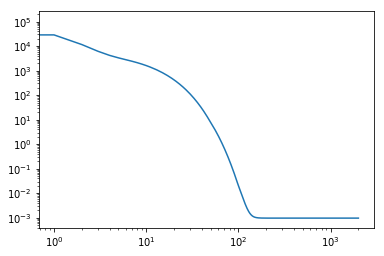

In [1177]:
import matplotlib.pyplot as plt
plt.loglog(reg.j_hist)

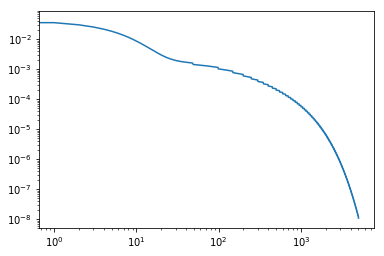

In [513]:
plt.loglog(np.array(dv_hist)*-1)

In [343]:
reg.var.val 

array([[ 1.27959871e+00,  1.27361709e+00,  1.60651565e-01],
       [-5.99621510e-02,  1.13820246e+00,  2.65531557e-02],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [344]:
test_x = (data_x[:,0] - reg.x_mean) / reg.x_std
test_y = (data_y[:,0] - reg.y_mean) / reg.y_std

In [346]:
pred_y = np.dot(reg.var.val, test_x)

ValueError: shapes (3,3) and (4,) not aligned: 3 (dim 1) != 4 (dim 0)

In [420]:
test_y

array([ 1.57175111,  1.17644567, -0.80010062])

In [421]:
pred_y

array([ 1.57144881,  1.17683568, -0.80574305])

In [462]:
t_m

array([[0.82644675, 0.88120926, 0.01278923],
       [0.65749945, 0.44678613, 0.23924547],
       [0.07954453, 0.92108736, 1.        ]])

In [463]:
np.dot(x.T, res)

ValueError: shapes (1,100) and (50,3) not aligned: 100 (dim 1) != 50 (dim 0)

NameError: name 'self' is not defined

In [123]:
for i in range(self.iter):
    pred = np.dot(x, self.var.val)
    # Loss L2norm
    res = pred - y
    loss = 1/(2 * m) *np.sum(res * res) / (n)
    self.j_hist[i,0] = loss
    if (loss < self.err_th):
        return self.var.val
    # Gradient
    dV = (self.ir / m) * np.dot(x.T, res)
    DEBUG('==============',i,'============')
    DEBUG('res:',res[0,...], 'pred:',pred[0,...], 'y:',y[0,...])
    DEBUG('loss:',loss, 'dV:',dV[0,:], 'x:',x.T.shape, 'res:',res.shape)
    # Update variable
    if self.var.trainable:
        self.var.val -= (dV * self.var.train_mask)

array([[0.40377134, 0.51165326, 0.11446054],
       [0.14409324, 0.02794739, 0.74226507],
       [0.65643921, 0.66324733, 1.        ]])

In [480]:
def compute_cost(X, y, params):
    n_samples = len(y)
    h = X @ params
    return (1/(2*n_samples))*np.sum((h-y)**2)
def gradient_descent(X, y, params, learning_rate, n_iters):
    n_samples = len(y)
    J_history = np.zeros((n_iters,1))

    for i in range(n_iters):
        params = params - (learning_rate/n_samples) * X.T @ (X @ params - y) 
        J_history[i] = compute_cost(X, y, params)

    return (J_history, params)

In [481]:
import numpy as np
from sklearn.datasets import load_boston
import matplotlib.pyplot as plt

In [482]:
dataset = load_boston()

X = dataset.data
y = dataset.target[:,np.newaxis]

print("Total samples in our dataset is: {}".format(X.shape[0]))


Total samples in our dataset is: 506


In [229]:
n_samples = len(y)

mu = np.mean(X, 0)
sigma = np.std(X, 0)

X = (X-mu) / sigma

X = np.hstack((np.ones((n_samples,1)),X))
n_features = np.size(X,1)
params = np.zeros((n_features,1))

Initial cost is:  296.0734584980237 

Optimal parameters are: 
 [[22.53279993]
 [-0.83980839]
 [ 0.92612237]
 [-0.17541988]
 [ 0.72676226]
 [-1.82369448]
 [ 2.78447498]
 [-0.05650494]
 [-2.96695543]
 [ 1.80785186]
 [-1.1802415 ]
 [-1.99990382]
 [ 0.85595908]
 [-3.69524414]] 

Final cost is:  [11.00713381]


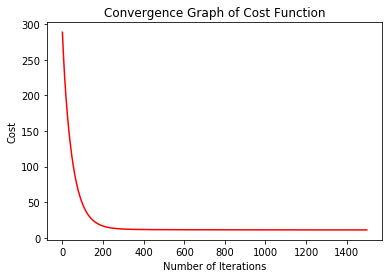

In [230]:
n_iters = 1500
learning_rate = 0.01

initial_cost = compute_cost(X, y, params)

print("Initial cost is: ", initial_cost, "\n")

(J_history, optimal_params) = gradient_descent(X, y, params, learning_rate, n_iters)

print("Optimal parameters are: \n", optimal_params, "\n")

print("Final cost is: ", J_history[-1])

plt.plot(range(len(J_history)), J_history, 'r')

plt.title("Convergence Graph of Cost Function")
plt.xlabel("Number of Iterations")
plt.ylabel("Cost")
plt.show()

In [278]:
class LinearRegression():
    def __init__(self, X, y, alpha=0.03, n_iter=1500):

        self.alpha = alpha
        self.n_iter = n_iter
        self.n_samples = len(y)
        self.n_features = np.size(X, 1)
        self.X = np.hstack((np.ones(
            (self.n_samples, 1)), (X - np.mean(X, 0)) / np.std(X, 0)))
        self.y = y[:, np.newaxis]
        self.params = np.zeros((self.n_features + 1, 1))
        self.coef_ = None
        self.intercept_ = None
    def fit(self):

        for i in range(self.n_iter):
            self.params = self.params - (self.alpha/self.n_samples) * \
            self.X.T @ (self.X @ self.params - self.y)

        self.intercept_ = self.params[0]
        self.coef_ = self.params[1:]

        return self

    def score(self, X=None, y=None):

        if X is None:
            X = self.X
        else:
            n_samples = np.size(X, 0)
            X = np.hstack((np.ones(
                (n_samples, 1)), (X - np.mean(X, 0)) / np.std(X, 0)))

        if y is None:
            y = self.y
        else:
            y = y[:, np.newaxis]

        y_pred = X @ self.params
        score = 1 - (((y - y_pred)**2).sum() / ((y - y.mean())**2).sum())

        return score

    def predict(self, X):
        n_samples = np.size(X, 0)
        y = np.hstack((np.ones((n_samples, 1)), (X-np.mean(X, 0)) \
                            / np.std(X, 0))) @ self.params
        return y

    def get_params(self):

        return self.params

In [296]:
a = 2.71
b = -2
N = 100
x = np.linspace(0, 10, N)
x = np.expand_dims(x,1)
y = a *x + b + np.random.rand(N,1) / 0.01


In [298]:
lr = LinearRegression(x,y)
lr.fit()

In [16]:
class Variables(object):
    """
    Variable that can used to train with mask
    """
    __slots__ = ('train_mask','dim','trainable','val')
    def __init__(self, val=None, dim=None, trainable=1):
        self.dim = dim
        if val is None:
            self.val = np.random.rand(dim[0],dim[1])
            #self.val = np.zeros((dim[0],dim[1]))
        else:
            assert val.shape == dim, "input val not consistent to dim input"
            self.val = val
        self.train_mask = np.ones_like(self.val)
        self.trainable = trainable
    def set_trainMask(self, mask):
        assert mask.shape == self.dim
        self.train_mask = mask
    def update(self, dv):
        if self.trainable:
            self.val -= (dv * self.train_mask)


In [64]:
class Regression(object):
    """
    Note. Training gradient may explode if lr is too large.
    """
    __slots__ = ('var', 'iter', 'lr', 'err_th', 'j_hist',
                'x_mean', 'y_mean', 'x_std', 'y_std',
                'decay_rate', 'loss_weights','norm')
    def __init__(self, var=None, iter=500, decay_rate=0.9, norm=1):
        self.var = var
        self.iter = iter
        self.lr = 0.001
        self.err_th = 1e-4
        self.j_hist = np.zeros((self.iter,1))
        self.decay_rate=0.9
        self.loss_weights=None
        self.norm = norm

    def process(self, x, y):
        #self.x_mean = np.mean(x)
        self.x_std = np.std(x)
        #self.y_mean = np.mean(y)
        #self.y_std = np.std(y)
        #_x = (x.copy() - self.x_mean)/self.x_std
        #_y = (y.copy() - self.y_mean)/self.y_std
        _x = x.copy()/self.x_std
        _y = y.copy()/self.x_std
        return _x, _y
        #return x.copy(), y.copy()
    
    def pred(x,val):
        return np.dot(x, val)
    
    def compute_cost(x, val, y):
        m, n = y.shape
        pred = Regression.pred(x, val)
        dloss = pred - y
        cost = np.sum(dloss * dloss) / (2 * m * n)
        
    def fit(self, x, y):
        assert len(x.shape) == 2, 'shape of x is not support'
        assert self.var.dim[0] == x.shape[1], 'shape of x %s is not consistent to var dim %s' % (self.var.dim, x.shape)
        assert self.var.dim[1] == y.shape[1], 'shape of y %s is not consistent to var dim %s' % (self.var.dim, y.shape)
        m, n = x.shape
        print('processing data')
        _x, _y = self.process(x, y)
        dv_hist = []
        lr= self.lr
        method = 'L2norm'
        for i in range(self.iter):
            if i % 200 == 0:
                lr *= self.decay_rate
            pred = np.dot(_x, self.var.val)
            # Loss L2norm
            if self.loss_weights is not None:
                res = (pred - _y) * self.loss_weights
            else:
                res = (pred - _y)
            if method == 'L2norm':
                invH = np.linalg.inv(self.var.val)
                reproj = np.dot(pred, invH)
                res_re = (reproj - _x) * self.loss_weights
                loss = np.sum(res * res) / (2 * m * n) + np.sum(res_re * res_re) / (2 * m * n)
            elif method == 'LMS':
                loss = np.sum(np.median(res * res, axis=0)) / (2 * n)
            if self.norm > 0:
                loss += (np.sum(self.var.val ** 2) - 1) / 2 * self.norm
            self.j_hist[i,0] = loss
            if (loss < self.err_th):
                return self.var.val
            # Gradient
            if method == 'L2norm':
                # https://math.stackexchange.com/questions/190424/how-to-evaluate-the-derivatives-of-matrix-inverse
                tV = np.dot(_x.T, res) / m
                dH = -np.dot(np.dot(invH, self.var.val.T), invH)
                dR = np.dot(pred, dH)
                tV += (np.dot(dR.T, res_re) / m)
                if self.norm > 0:
                    tV += self.var.val * self.norm 
                dV = lr * tV
                dv_hist.append(dV[0,0])
            elif method == 'LMS':
                dV = (lr) # working on
            DEBUG('==============',i,'============', 'loss',loss, lr)
            # Update variable
            if self.var.trainable:
                self.var.val -= (dV * self.var.train_mask)
        print("iter Done! Final loss:", loss)
        return dv_hist
            #self.var.update(dV, self.ir, m)

In [155]:
rand = np.random.rand(N,N)
var  = Variables(val=rand,dim=(N,N))
#var  = Variables(dim=(N,N))
var.val[N-1,N-1] = 1.0
mask = np.ones_like(t_m)
mask[-1,:] = 1
mask[N-1,N-1] = 0
var.set_trainMask(mask)
reg = Regression(var=var,iter=1000)
reg.err_th = 1e-10
#reg.lr = 0.000001
#reg.lr = np.ones((N,N)) * 0.01
#reg.lr[-1,:] = 0.0001
reg.lr = 0.1
reg.norm = 1e-8
reg.loss_weights = np.array([[1,1,1]])

In [156]:
dv_hist = reg.fit(data_x, data_y)

processing data
============== 0 ============ loss 116014.94453889747 0.09000000000000001
============== 1 ============ loss 22144.163619434694 0.09000000000000001
============== 2 ============ loss 6089.0714430236585 0.09000000000000001
============== 3 ============ loss 3273.3673188490893 0.09000000000000001
============== 4 ============ loss 2712.7321334867115 0.09000000000000001
============== 5 ============ loss 2538.658798665922 0.09000000000000001
============== 6 ============ loss 2433.211939650282 0.09000000000000001
============== 7 ============ loss 2342.2069540665484 0.09000000000000001
============== 8 ============ loss 2256.326148113136 0.09000000000000001
============== 9 ============ loss 2173.887221394699 0.09000000000000001
============== 10 ============ loss 2094.5101826155715 0.09000000000000001
============== 11 ============ loss 2018.0399845150655 0.09000000000000001
============== 12 ============ loss 1944.3631428361227 0.09000000000000001
============== 13 =====

============== 118 ============ loss 37.726046908211856 0.09000000000000001
============== 119 ============ loss 36.34874191500853 0.09000000000000001
============== 120 ============ loss 35.021720929076224 0.09000000000000001
============== 121 ============ loss 33.74314813274945 0.09000000000000001
============== 122 ============ loss 32.511254732179815 0.09000000000000001
============== 123 ============ loss 31.32433651036591 0.09000000000000001
============== 124 ============ loss 30.180751469519826 0.09000000000000001
============== 125 ============ loss 29.078917559506188 0.09000000000000001
============== 126 ============ loss 28.01731048921618 0.09000000000000001
============== 127 ============ loss 26.99446161784433 0.09000000000000001
============== 128 ============ loss 26.008955923153707 0.09000000000000001
============== 129 ============ loss 25.05943004391651 0.09000000000000001
============== 130 ============ loss 24.144570393824324 0.09000000000000001
============== 131

============== 262 ============ loss 0.22570251284208398 0.08100000000000002
============== 263 ============ loss 0.21831116516551327 0.08100000000000002
============== 264 ============ loss 0.21116291011560792 0.08100000000000002
============== 265 ============ loss 0.20424975268781856 0.08100000000000002
============== 266 ============ loss 0.19756396082259015 0.08100000000000002
============== 267 ============ loss 0.19109805675757918 0.08100000000000002
============== 268 ============ loss 0.18484480866408198 0.08100000000000002
============== 269 ============ loss 0.17879722255867905 0.08100000000000002
============== 270 ============ loss 0.17294853448075748 0.08100000000000002
============== 271 ============ loss 0.16729220292741193 0.08100000000000002
============== 272 ============ loss 0.16182190153712836 0.08100000000000002
============== 273 ============ loss 0.15653151201398585 0.08100000000000002
============== 274 ============ loss 0.1514151172847922 0.08100000000000002


============== 394 ============ loss 0.003685811862059613 0.08100000000000002
============== 395 ============ loss 0.0035963618601692797 0.08100000000000002
============== 396 ============ loss 0.003509853897663259 0.08100000000000002
============== 397 ============ loss 0.0034261912124012367 0.08100000000000002
============== 398 ============ loss 0.0033452802246455946 0.08100000000000002
============== 399 ============ loss 0.003267030432427864 0.08100000000000002
============== 400 ============ loss 0.0031913543102859085 0.07290000000000002
============== 401 ============ loss 0.0031254308476047193 0.07290000000000002
============== 402 ============ loss 0.003061460446536621 0.07290000000000002
============== 403 ============ loss 0.0029993852469360326 0.07290000000000002
============== 404 ============ loss 0.002939149102754309 0.07290000000000002
============== 405 ============ loss 0.0028806975312610427 0.07290000000000002
============== 406 ============ loss 0.002823977663785937

============== 532 ============ loss 0.0010082589386043977 0.07290000000000002
============== 533 ============ loss 0.0010070150477054201 0.07290000000000002
============== 534 ============ loss 0.0010058080217918597 0.07290000000000002
============== 535 ============ loss 0.0010046367685281061 0.07290000000000002
============== 536 ============ loss 0.0010035002279409756 0.07290000000000002
============== 537 ============ loss 0.001002397371463358 0.07290000000000002
============== 538 ============ loss 0.0010013272010006076 0.07290000000000002
============== 539 ============ loss 0.0010002887480309516 0.07290000000000002
============== 540 ============ loss 0.0009992810727265818 0.07290000000000002
============== 541 ============ loss 0.0009983032631053898 0.07290000000000002
============== 542 ============ loss 0.0009973544342055227 0.07290000000000002
============== 543 ============ loss 0.0009964337272843676 0.07290000000000002
============== 544 ============ loss 0.00099554030904

============== 688 ============ loss 0.0009668006797206002 0.06561000000000002
============== 689 ============ loss 0.0009667873536254029 0.06561000000000002
============== 690 ============ loss 0.0009667743844593516 0.06561000000000002
============== 691 ============ loss 0.0009667617626805677 0.06561000000000002
============== 692 ============ loss 0.0009667494790019137 0.06561000000000002
============== 693 ============ loss 0.0009667375243844198 0.06561000000000002
============== 694 ============ loss 0.0009667258900304918 0.06561000000000002
============== 695 ============ loss 0.0009667145673774964 0.06561000000000002
============== 696 ============ loss 0.0009667035480915269 0.06561000000000002
============== 697 ============ loss 0.000966692824061232 0.06561000000000002
============== 698 ============ loss 0.0009666823873919451 0.06561000000000002
============== 699 ============ loss 0.0009666722303998806 0.06561000000000002
============== 700 ============ loss 0.00096666234560

============== 868 ============ loss 0.0009663089577844541 0.05904900000000002
============== 869 ============ loss 0.0009663088547838579 0.05904900000000002
============== 870 ============ loss 0.0009663087543644181 0.05904900000000002
============== 871 ============ loss 0.0009663086564628259 0.05904900000000002
============== 872 ============ loss 0.0009663085610173104 0.05904900000000002
============== 873 ============ loss 0.0009663084679675972 0.05904900000000002
============== 874 ============ loss 0.0009663083772548809 0.05904900000000002
============== 875 ============ loss 0.0009663082888217737 0.05904900000000002
============== 876 ============ loss 0.0009663082026122944 0.05904900000000002
============== 877 ============ loss 0.0009663081185718121 0.05904900000000002
============== 878 ============ loss 0.0009663080366470291 0.05904900000000002
============== 879 ============ loss 0.0009663079567859404 0.05904900000000002
============== 880 ============ loss 0.0009663078789

In [153]:
t_m

array([[ 7.92272362e-01,  8.22117652e-02,  4.34671442e+02],
       [-1.33501977e-01,  9.58413827e-01,  6.55962640e+01],
       [-2.09248580e-04,  1.60937718e-05,  1.00000000e+00]])

In [158]:
reg.var.val

array([[ 7.90900075e-01,  8.06359397e-02,  4.34671372e+02],
       [-1.33281047e-01,  9.58667338e-01,  6.55963190e+01],
       [ 6.01986564e-01,  6.91658939e-01,  1.00000000e+00]])

In [160]:
for idx in range(4):
    test_x = data_x[idx]
    test_y = data_y[idx]
    pred_y = np.dot(data_x[idx], reg.var.val)
    print (data_x[idx], test_y, pred_y)

[366 632   1] [   205.59822578    635.80706082 200547.58662   ] [   205.83779247    636.08217029 200547.59589302]
[691 937   1] [   422.36864044    954.84210175 361822.66579   ] [   422.22959761    954.68238868 361822.66920104]
[386  74   1] [2.95937776e+02 1.02656381e+02 1.72638300e+05] [2.96026618e+02 1.02758515e+02 1.72638277e+05]
[570 609   1] [   370.2923331    630.5347429 287711.846716 ] [   370.24687188    630.48255322 287711.84051069]


In [150]:
data_x

array([[366, 632,   1],
       [691, 937,   1],
       [386,  74,   1],
       [570, 609,   1]])

In [ ]:
class Regression(object):
    """
    Note. Training gradient may explode if lr is too large.
    """
    __slots__ = ('var', 'iter', 'lr', 'err_th', 'j_hist',
                'x_mean', 'y_mean', 'x_std', 'y_std',
                'decay_rate', 'loss_weights','norm')
    def __init__(self, var=None, iter=500, decay_rate=0.9, norm=1):
        self.var = var
        self.iter = iter
        self.lr = 0.001
        self.err_th = 1e-4
        self.j_hist = np.zeros((self.iter,1))
        self.decay_rate=0.9
        self.loss_weights=None
        self.norm = norm

    def process(self, x, y):
        #self.x_mean = np.mean(x)
        self.x_std = np.std(x)
        #self.y_mean = np.mean(y)
        #self.y_std = np.std(y)
        #_x = (x.copy() - self.x_mean)/self.x_std
        #_y = (y.copy() - self.y_mean)/self.y_std
        _x = x.copy()/self.x_std
        _y = y.copy()/self.x_std
        return _x, _y
        #return x.copy(), y.copy()
    
    def pred(x,val):
        return np.dot(x, val)
    
    def compute_cost(x, val, y):
        m, n = y.shape
        pred = Regression.pred(x, val)
        dloss = pred - y
        cost = np.sum(dloss * dloss) / (2 * m * n)
    
    
    def fit(self, x, y):
        assert len(x.shape) == 2, 'shape of x is not support'
        assert self.var.dim[0] == x.shape[1], 'shape of x %s is not consistent to var dim %s' % (self.var.dim, x.shape)
        assert self.var.dim[1] == y.shape[1], 'shape of y %s is not consistent to var dim %s' % (self.var.dim, y.shape)
        m, n = x.shape
        print('processing data')
        _x, _y = self.process(x, y)
        dv_hist = []
        lr= self.lr
        method = 'L2norm'
        for i in range(self.iter):
            if i % 200 == 0:
                lr *= self.decay_rate
            pred = np.dot(_x, self.var.val)
            # Loss L2norm
            if self.loss_weights is not None:
                res = (pred - _y) * self.loss_weights
            else:
                res = (pred - _y)
            if method == 'L2norm':
                loss = np.sum(res * res) / (2 * m * n)
            if self.norm > 0:
                loss += (np.sum(self.var.val ** 2) - 1) / 2 * self.norm
            self.j_hist[i,0] = loss
            if (loss < self.err_th):
                return self.var.val
            # Gradient
            if method == 'L2norm':
                tV = np.dot(_x.T, res) / m
                if self.norm > 0:
                    tV += self.var.val * self.norm 
                dV = lr * tV
                dv_hist.append(dV[0,0])
            DEBUG('==============',i,'============', 'loss',loss, lr)
            # Update variable
            if self.var.trainable:
                self.var.val -= (dV * self.var.train_mask)
        print("iter Done! Final loss:", loss)
        return dv_hist
            #self.var.update(dV, self.ir, m)

In [990]:
res = np.array([[188.51387797, 188.25674871, 190.24676645, 185.97885747],
 [194.12135314, 191.07547677, 189.01739573, 194.65284295],
 [ -1.82874661,   0.91050942,  -1.23402567,   2.45709586]]) 
xT = np.array([[-2.50696386, -5.9552604,   1.        ],
 [ 0.96999609,  2.84768042,  1.        ],
 [-3.60295508, -0.58000537,  1.        ],
 [ 5.13992285,  3.68758535,  1.        ]] )
tv = np.array([[-1.95227435e+01, -1.10854111e+01,  7.52996251e+02],
 [ 1.81666577e+01, -3.75344571e+00,  7.68867069e+02],
 [ 2.25432145e+01,  2.32599944e+01,  3.04832992e-01]])

In [994]:
(188.51387797 * -2.50696386)  + (188.25674871 * 0.96999609) +  (190.24676645*-3.60295508) + (185.97885747 * 5.13992285)

-19.52274352208258

In [993]:
np.dot(res[0,:],xT[:,0])

-19.52274352208258

In [991]:
res @ xT

array([[-1.95227435e+01, -1.10854110e+01,  7.52996251e+02],
       [ 1.81666577e+01, -3.75344576e+00,  7.68867069e+02],
       [ 2.25432144e+01,  2.32599943e+01,  3.04833000e-01]])

In [978]:
tv [[-2.04379374e-02  1.77674701e-02  1.24713524e+02]
 [ 2.77237708e-02 -2.41013200e-02  1.27342097e+02]
 [ 4.63450171e-03 -4.02894719e-03  3.04832992e-01]]
dv [-1.02189687e-04  8.88373504e-05  6.23567619e-01] val [ 0.79079653  0.08349476 34.54371102]

array([[-1.95227435e+01, -1.10854111e+01,  7.52996251e+02],
       [ 1.81666577e+01, -3.75344571e+00,  7.68867069e+02],
       [ 2.25432145e+01,  2.32599944e+01,  3.04832992e-01]])

In [998]:
1.24713524e+02 * 0.02 / 4

0.6235676200000001